In [1]:
from basic_tools import *
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
h2_total=pd.read_csv(h2_total_par_filtered_path,index_col='phenotype')
h2_total.shape

(497, 7622)

# Parsing result of partitioned LDSC

In [3]:
suffix_bp_list_power="bp300 bp128 bp64 bp32 bp16 bp8".split()

In [4]:
regression_result_bp_list_dict=dict([make_regression_result_list(h2_total,phenotype,suffix_bp_list_power) for phenotype in phenotypes_par_filtered.index])

# Plotting

In [5]:
def regression_result_groupchr(regression_result):
    regression_result_temp=regression_result.copy()
    regression_result_temp['h2_ratio']=regression_result_temp['h2']/regression_result_temp['h2'].sum()
    regression_result_temp['chr']=regression_result_temp['category'].apply(lambda x:category_to_format(x,'chr'))
    regression_result_temp_chr=dict([(idx,regression_result_temp.loc[value]) for idx,value in regression_result_temp.groupby('chr').groups.items()])    
    return regression_result_temp_chr

In [6]:
def absorb_negative(array):
    array=np.array(array)
    for i in range(len(array)):
        if array[i]<0:
            if i<len(array)-1:
                array[i+1]=array[i+1]+array[i]
                array[i]=0
            else:
                array[i]=0
    return array

In [7]:
plt.rcParams['font.family']='Arial'

In [41]:
plt.rcParams['font.size']

10.0

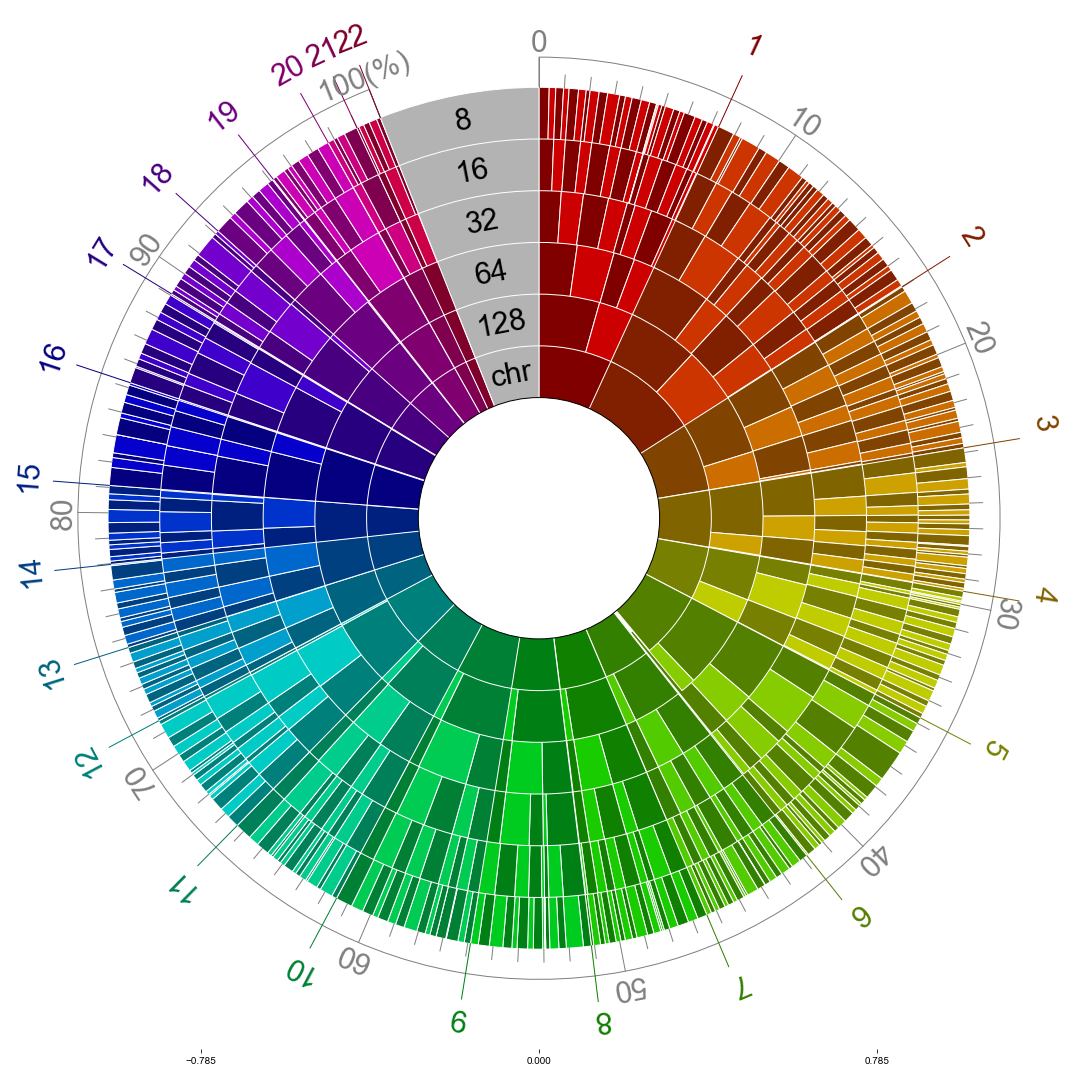

In [44]:
def plot_par_pie(regression_result_list,middle_interval_ratio=0.1,top_interval_ratio=0.05,absorb=True,reverse_order=True):
    plt.rcParams["figure.figsize"] = (15,15)
    plt.rcParams['font.size']=10
    size =0.3

    
    regression_result_list=regression_result_list.copy()[::-1] if reverse_order else regression_result_list.copy()
        
    regression_result_ref=regression_result_list[0].copy()
    regression_result_ref['h2_ratio']=regression_result_ref['h2']/regression_result_ref['h2'].sum()
    regression_result_ref['chr']=regression_result_ref['category'].apply(lambda x:category_to_format(x,'chr'))

    regression_result_chrdict_list=[regression_result_groupchr(regression_result) for regression_result in regression_result_list]
        
    fig, ax = plt.subplots()
    #fig = plt.figure()
    #ax = fig.add_subplot(111, polar=True)
    
    r_big=np.linspace(1, 1.07, 1000)
    r_small=np.linspace(1, 1.03, 1000)
    #r_middle=np.linspace(1, 1.04, 1000)
    
    for idx,ratio in enumerate(np.arange(0, 1.0001, 0.01)):
        theta=np.pi/2-2*np.pi*(1-top_interval_ratio)*ratio
        if idx%10==0:
            x=r_big*np.cos(theta)
            y=r_big*np.sin(theta)
            plt.plot(x, y,color='grey',linewidth=1);
            
            plt.text(1.03*x[-1],1.03*y[-1],'{:.0f}'.format(ratio*100)+ ('(%)'if ratio==1 else ''),color='grey',rotation=180/np.pi*(+theta-np.pi/2),fontsize=plt.rcParams['font.size']*3,horizontalalignment='center',verticalalignment='center')
        else:
            x=r_small*np.cos(theta)
            y=r_small*np.sin(theta)
            
            plt.plot(x, y,color='grey',linewidth=1);
    plt.pie([1-top_interval_ratio],radius=r_big[-1],colors=[(1,1,1,1)],startangle=90,counterclock=False,wedgeprops=dict(width=size, edgecolor='grey'))
    #centre_circle = plt.Circle((0,0),r_big[-1],fc=(1,1,1,0),edgecolor='grey')#,', fc='white',linewidth=1,edgecolor='grey')
    
    #fig.gca().add_artist(centre_circle)
            
            
    r_chr_annot=np.linspace(1, 1.13, 1000)
    for idx,regression_result_chrdict in enumerate(regression_result_chrdict_list):#for each scale
        for chrN,regression_result_chr in regression_result_chrdict.items():#for each chromosome
            data=regression_result_chr['h2_ratio']*(1-middle_interval_ratio)
            if absorb:
                data=absorb_negative(data)
            startangle=90.0-360.0*middle_interval_ratio/len(regression_result_chrdict.keys())*(chrN-1)-360.0*regression_result_ref[regression_result_ref['chr']<chrN]['h2_ratio'].sum()*(1-middle_interval_ratio)
            
            data=data*(1-top_interval_ratio)
            startangle=startangle*(1-top_interval_ratio)+90*top_interval_ratio
            radius=1-(1-0.4)/(len(regression_result_list)-1)*idx
            #startangle=startangle+360*top_interval_ratio
            color_list=[np.array(plt.cm.get_cmap('hsv')((chrN-1)/22))[:-1]*0.5,np.array(plt.cm.get_cmap('hsv')((chrN-1)/22))[:-1]*0.8]
            
            if idx==0:                
                theta=startangle/180*np.pi-2*np.pi*data.sum()
                x=r_chr_annot*np.cos(theta)
                y=r_chr_annot*np.sin(theta)
                plt.plot(x, y,color=color_list[0],linewidth=1);
                plt.text(1.05*x[-1],1.05*y[-1],chrN,rotation=180/np.pi*(+theta-np.pi/2),color=color_list[0],fontsize=plt.rcParams['font.size']*3,horizontalalignment='center')
                #plt.text(r_big[-1]*np.cos(theta),r_big[-1]*np.sin(theta),chrN,rotation=180/np.pi*(+theta-np.pi/2))
                
            
            ax.set_prop_cycle(color=color_list)
            plt.pie(data,radius=radius,startangle=startangle,counterclock=False,wedgeprops=dict(width=size, edgecolor='w'))
        
        plt.pie([top_interval_ratio],radius=radius,colors=[(0.7,0.7,0.7,1)],startangle=90,counterclock=True,wedgeprops=dict(width=size, edgecolor='w'))

        radius=1-(1-0.4)/(len(regression_result_list)-1)*(idx+0.5)
        theta=np.pi/2+np.pi*top_interval_ratio
        text=category_to_format(regression_result_list[idx]['category'][0],mode='scale')
        text='chr' if text==300 else str(text)
        plt.text(radius*np.cos(theta),radius*np.sin(theta),text,rotation=180/np.pi*(+theta-np.pi/2),color='black',fontsize=plt.rcParams['font.size']*3,horizontalalignment='center',verticalalignment='center')

    
    centre_circle = plt.Circle((0,0),0.4-(1-0.4)/(len(regression_result_list)-1),color='black', fc='white',linewidth=1,edgecolor='grey')
    #fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 8, endpoint=False))
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('test.svg')
    
plot_par_pie(regression_result_bp_list_dict['23115_irnt'],middle_interval_ratio=0.0,top_interval_ratio=0.06)

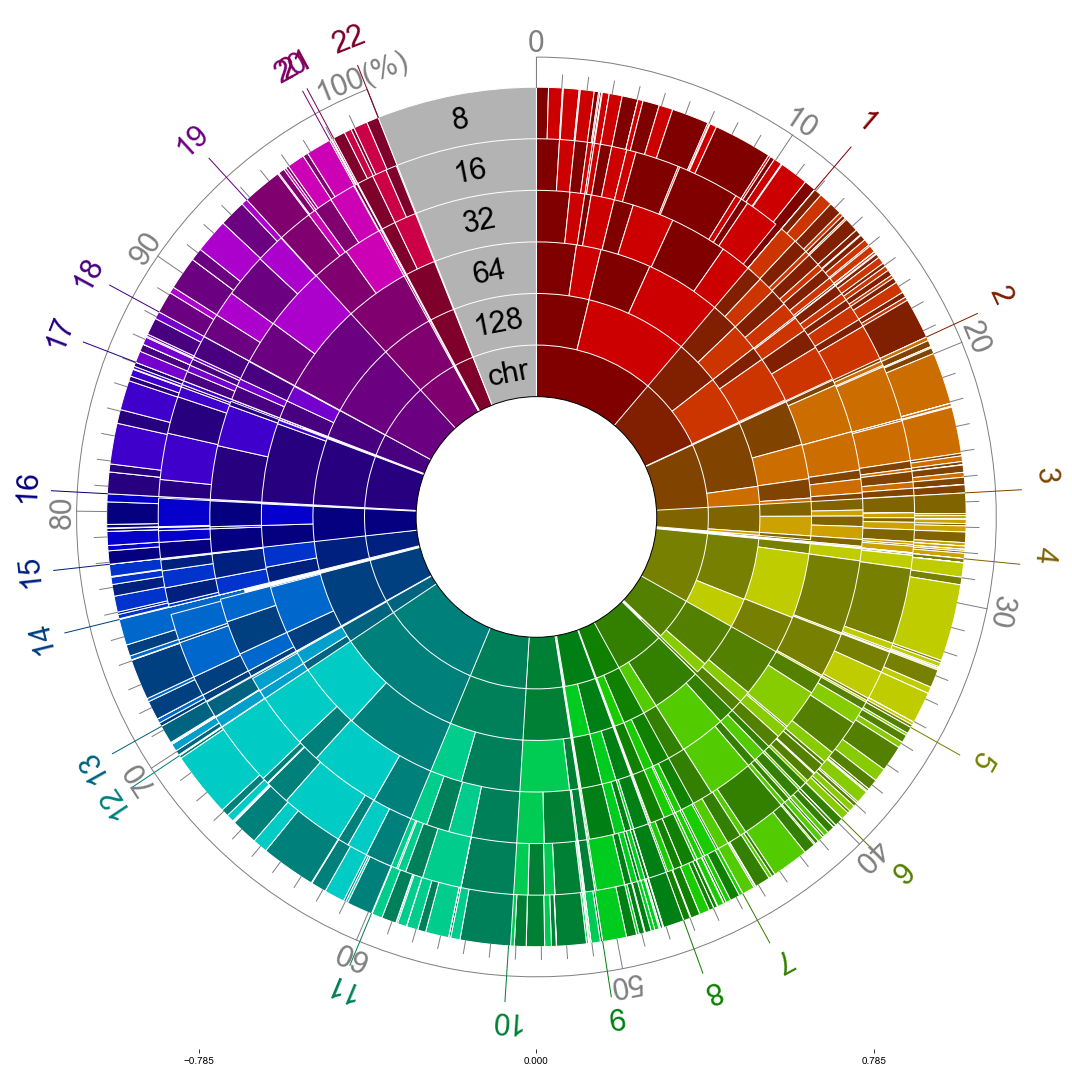

In [45]:
plot_par_pie(regression_result_bp_list_dict['30100_irnt'],middle_interval_ratio=0.0,top_interval_ratio=0.06)